In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model, load_model
from tensorflow.keras import mixed_precision
import keras.backend as K
import pandas as pd
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import splitfolders
import zipfile
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
import shutil
import sys
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import locale
locale.setlocale(locale.LC_ALL, 'bn_BD.UTF-8')
from keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('train.csv')

In [3]:
grapheme_roots = df['grapheme_root'].values
n, c = np.unique(grapheme_roots, return_counts=True)
total_grapheme_roots = len(n)

vowel_diacritic = df['vowel_diacritic'].values
n, c = np.unique(vowel_diacritic, return_counts=True)
total_vowel_diacritic = len(n)

consonant_diacritic = df['consonant_diacritic'].values
n, c = np.unique(consonant_diacritic, return_counts=True)
total_consonant_diacritic = len(n)

In [4]:
def simple_model():

    f = 16
    x = Input(shape=(120,120,1,))
    init=x

    conv = Conv2D(f, 3, strides=1, padding='same', activation='relu')(init)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*2, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*4, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*8, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)


    conv = Conv2D(f*16, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    f = Flatten()(conv)

    d_grapheme_root = Dense(512, activation='relu')(f)
    d_grapheme_root = Dropout(0.5)(d_grapheme_root)
    d_grapheme_root = Dense(256, activation='relu')(d_grapheme_root)

    d_vowel_diacritic = Dense(512, activation='relu')(f)
    d_vowel_diacritic = Dropout(0.5)(d_vowel_diacritic)
    d_vowel_diacritic = Dense(256, activation='relu')(d_vowel_diacritic)

    d_consonant_diacritic = Dense(512, activation='relu')(f)
    d_consonant_diacritic = Dropout(0.5)(d_consonant_diacritic)
    d_consonant_diacritic = Dense(256, activation='relu')(d_consonant_diacritic)


    grapheme_root = Dense(total_grapheme_roots, activation='softmax', name='grapheme_root')(d_grapheme_root)
    vowel_diacritic = Dense(total_vowel_diacritic, activation='softmax', name='vowel_diacritic')(d_vowel_diacritic)
    consonant_diacritic = Dense(total_consonant_diacritic, activation='softmax', name='consonant_diacritic')(d_consonant_diacritic)


    model = Model(inputs=x, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])

    return model

model = simple_model()

In [5]:
# FOR RECONSTRUCTION PURPOSE
df_gr = pd.read_csv('train.csv')
df_gr = df_gr.drop_duplicates(subset=['grapheme'])
dv = df_gr.values
grapheme_roots = []
_grapheme_roots = []

for v in dv:
    if v[1] != 0 and v[2] == 0 and v[3] == 0 and v[-1] not in _grapheme_roots:
        _grapheme_roots.append(v[-1])
        grapheme_roots.append({'numeric': v[1], 'value': v[-1]})

vowel_diacritics = {}
vowel_diacritics[0] = ''
vowel_diacritics[1] = 'া'
vowel_diacritics[2] = 'ি'
vowel_diacritics[3] = 'ী'
vowel_diacritics[4] = 'ু'
vowel_diacritics[5] = 'ূ'
vowel_diacritics[6] = 'ৃ'
vowel_diacritics[7] = 'ে'
vowel_diacritics[8] = 'ৈ'
vowel_diacritics[9] = 'ো'
vowel_diacritics[10] = 'ৌ'


consonant_diacritics = {}
consonant_diacritics[0] = ''
consonant_diacritics[1] = 'ঁ'
consonant_diacritics[2] = '\u09b0\u09cd'
consonant_diacritics[3] = 'র্য' #//ref + ja fala
consonant_diacritics[4] = '্য'
consonant_diacritics[5] = '্র'
consonant_diacritics[6] = '্র্য'
consonant_diacritics[7] = 'র্্র'#ref + ra fala


def get_grapheme_root(numeric):
    for item in grapheme_roots:
        if item['numeric'] == numeric:
            return item['value']
    return ''

def get_vowel_diacritic(numeric):
    global vowel_diacritics
    return vowel_diacritics[numeric]

def get_consonant_diacritic(numeric):
    global consonant_diacritics
    return consonant_diacritics[numeric]



In [6]:
consonant_middle=[5,4,6]
consonant_after=[1]
consonant_before=[2]


In [7]:
def get_grapheme(gr,vd,cd):
    consonant_middle=[5,4,6]
    consonant_after=[1]


    if cd in consonant_middle:
        return get_grapheme_root(gr)+get_consonant_diacritic(cd)+get_vowel_diacritic(vd)
    elif cd==2:
        return get_consonant_diacritic(cd)+get_grapheme_root(gr)+get_vowel_diacritic(vd)
    elif cd==3:
        return '\u09b0\u09cd'+get_grapheme_root(gr)+'্য'+get_vowel_diacritic(vd)
    elif cd==7:
        return '\u09b0\u09cd'+get_grapheme_root(gr)+'্র'+get_vowel_diacritic(vd)
    elif cd in consonant_after:
        return get_grapheme_root(gr)+get_vowel_diacritic(vd)+get_consonant_diacritic(cd)

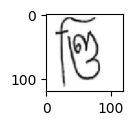

grapheme_root ণ্ড + constant_diacritic  + vowel_diacritic ি =  ণ্ডি
grapheme_root ণ্ড + vowel_diacritic ি + consonant_diacritic  =  ণ্ডি
Grapheme from CSV (Prediction) =  ণ্ডি


In [9]:
model.load_weights('test.hdf5')

y_true_grapheme_root = []
y_true_vowel_diacritic = []
y_true_consonant_diacritic = []

y_pred_grapheme_root = []
y_pred_vowel_diacritic = []
y_pred_consonant_diacritic = []

img = tf.keras.utils.load_img('image.png', color_mode='grayscale',target_size=(120, 120))
img = tf.keras.utils.img_to_array(img)/255.
img = np.expand_dims(img, axis=0)
pr = model.predict(img, verbose=0)

pred_grapheme_root = np.argmax(pr[0], axis=-1)[0]
pred_vowel_diacritic = np.argmax(pr[1], axis=-1)[0]
pred_consonant_diacritic = np.argmax(pr[2], axis=-1)[0]


y_pred_grapheme_root.append(pred_grapheme_root)
y_pred_vowel_diacritic.append(pred_vowel_diacritic)
y_pred_consonant_diacritic.append(np.argmax(pr[2], axis=-1)[0])


plt.rcParams["figure.figsize"] = (1,1)

plt.imshow(img[0, :, :, :], cmap='gray')
plt.show()

pred_grapheme_root_char = get_grapheme_root(pred_grapheme_root)
pred_vowel_diacritic_char = get_vowel_diacritic(pred_vowel_diacritic)
pred_consonant_diacritic_char = get_consonant_diacritic(pred_consonant_diacritic)


grapheme_pred = pred_grapheme_root_char + pred_vowel_diacritic_char + pred_consonant_diacritic_char

print('grapheme_root '+str(pred_grapheme_root_char)+' + constant_diacritic '+str(pred_consonant_diacritic_char)+' + vowel_diacritic '+str(pred_vowel_diacritic_char)+' = ', grapheme_pred)

grapheme_pred = pred_grapheme_root_char + pred_consonant_diacritic_char + pred_vowel_diacritic_char

print('grapheme_root '+str(pred_grapheme_root_char)+' + vowel_diacritic '+str(pred_vowel_diacritic_char)+' + consonant_diacritic '+str(pred_consonant_diacritic_char)+' = ', grapheme_pred)


grapheme_from_csv = df_gr.loc[(df['grapheme_root'] == pred_grapheme_root) & (df['vowel_diacritic'] == pred_vowel_diacritic) & (df['consonant_diacritic'] == pred_consonant_diacritic)].values[0][-1]

print("Grapheme from CSV (Prediction) = ", grapheme_from_csv)